
Session Params:
  dt_ms: 0.1, dt_secs: 0.0001, fs_Hz: 10000.0, nyquist_Hz: 5000.0
  bandpass filter: sosfiltfilt, f_bp_low_Hz: 20.0, f_bp_high_Hz: 2000.0, bandpass_order: 6
  wavelet: cmor0.5-1.0, num_scales: 50, scale_low: 0.1, scale_high: 50

compute_wavelet_transform -- logscales: False
  dt_ms: 0.1, wavelet: cmor0.5-1.0, num_scales: 50, scale_low: 0.1, scale_high: 50
  filter_type: sosfiltfilt, fc_low_Hz: 20.0, fc_high_Hz: 2000.0, bp_order: 6

cwt2 Params:
  voices_per_octave: 20, fs_Hz: 10000.0, min_freq_Hz: 1.0
  num_scales: 178, n_orig: 17999, n_padded: 35997


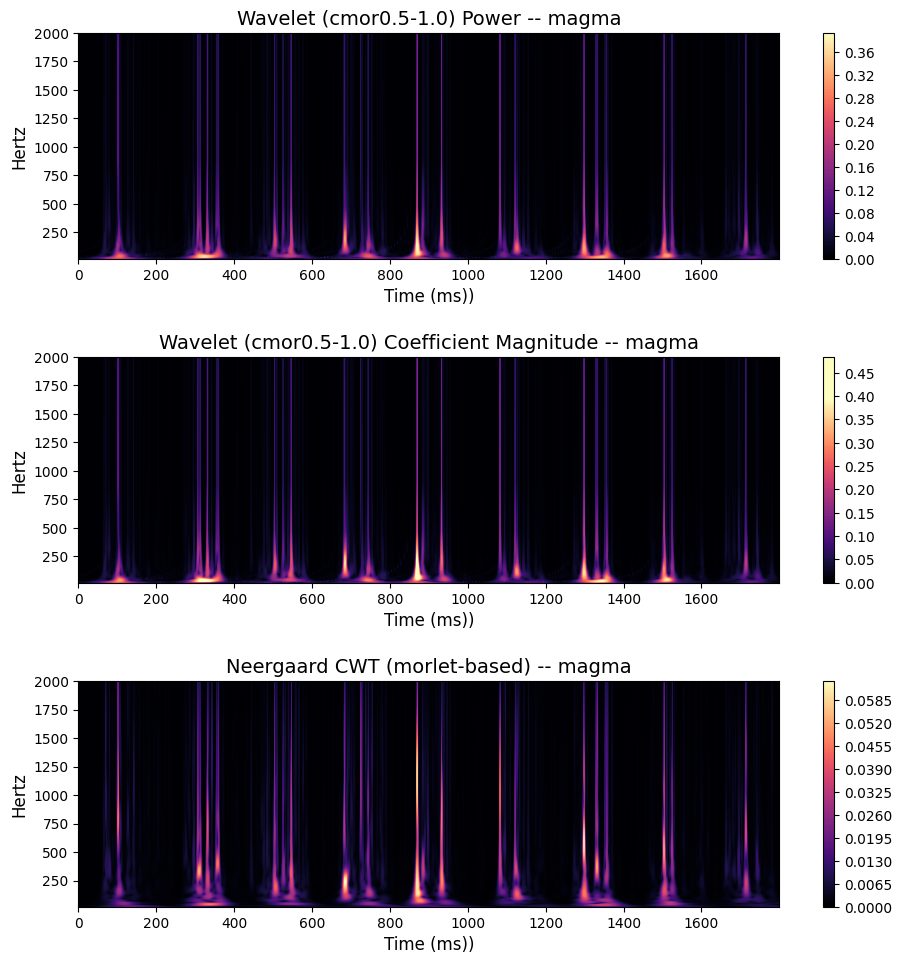

In [ ]:
"""
    cwt_neergaard_test.ipynb

    Continous Wavelet Transform (morlet-based) with voices_per_octave control

    Modified version of Neergaard code from: 
        https://www.kaggle.com/code/mistag/extracting-bird-song-signatures-with-wavelets
    Original code by Alexander Neergaard:
        https://github.com/neergaard/CWT
"""

import  math
import  numpy as np
import  matplotlib.pyplot as plt
from    scipy.signal import butter, sosfilt, sosfiltfilt, lfilter, filtfilt
from    scipy.interpolate import interp1d
import  pywt
import  pickle


# ----------------------------------------------------------------------------------------
def cwt2(data, voices_per_octave=10, fs_Hz=1.0, min_freq_Hz=0.0):
    """
    coeffs, freqs = cwt2(data, voices_per_octave, fs_Hz, min_freq_Hz)

    One dimensional Continuous Wavelet Transform (morlet-based).

    To analyze a signal at different freqs, the mother wavelet is stretched (larger scale, lower frequency) 
    or compressed (smaller scale, higher frequency).  These stretched/compressed wavelets are then shifted 
    (translated) along the signal to analyze it locally. 

    The number of octaves determines the span of frequencies being analyzed, while the number of 
    voices per octave determines the number of samples (scales) across this span.

    Increase the number of voices_per_octave to provide a finer resolution of the frequency content of the signal. 
    A smaller scale corresponds_scales_scales to a compressed wavelet, which represents higher frequencies. 
    A larger scale corresponds to a stretched wavelet, which represents lower frequencies. 

    Modified version of Neergaard code from: 
        https://www.kaggle.com/code/mistag/extracting-bird-song-signatures-with-wavelets
    Original code by Alexander Neergaard:
        https://github.com/neergaard/CWT

    Parameters
    ----------
        data:               input data
        voices_per_octave:  number of voices (wavelet scales) per octave
        fs_Hz:              sampling frequency (Hz)
        min_freq_Hz:        lowest frequency (Hz) of interest (limts longest scale)

    Returns
    -------
        coeffs :            array_like continous wavelet transform of the input signal
        freqs :             array_like frequencies (Hz)

    Notes
    -----
        Size of coefficients arrays is automatically calculated given the wavelet and the data length. 
        Currently, only the Morlet wavelet is supported.
    """

    data -= np.mean(data)
    n_orig = data.size

    # Pad data symmetrically
    padvalue = n_orig // 2
    x = np.concatenate((np.flipud(data[0:padvalue]), data, np.flipud(data[-padvalue:])))
    n_padded = x.size

    # Define scales
    _, wavscales = getDefaultScales(n_orig, voices_per_octave, fs_Hz, min_freq_Hz)
    num_scales = wavscales.size

    print('\ncwt2 Params:')
    print(f'  voices_per_octave: {voices_per_octave}, fs_Hz: {fs_Hz}, min_freq_Hz: {min_freq_Hz}')
    print(f'  num_scales: {num_scales}, n_orig: {n_orig}, n_padded: {n_padded}')


    # Frequency vector sampling the Fourier transform of the wavelet
    omega = np.arange(1, math.floor(n_padded / 2) + 1, dtype=np.float64)
    omega *= (2 * np.pi) / n_padded
    omega = np.concatenate((np.array([0]), omega, -omega[np.arange(math.floor((n_padded - 1) / 2), 0, -1, dtype=int) - 1]))

    # Compute FFT of the (padded) time series
    f = np.fft.fft(x)

    # Loop through all the scales and compute wavelet Fourier transform
    psift, freq = waveft(omega, wavscales)

    # Inverse transform to obtain the wavelet coefficients.
    cwtcfs = np.fft.ifft(np.kron(np.ones([num_scales, 1]), f) * psift)
    cfs = cwtcfs[:, padvalue:padvalue + n_orig]
    freq = freq * fs_Hz

    return cfs, freq


# ----------------------------------------------------------------------------------------
def getDefaultScales(n_size, voices_per_octave, fs_Hz, min_freq_Hz):

    # Smallest useful scale (default 2 for Morlet)
    scale_min = 2
    ds_scales = 1.0 / voices_per_octave

    # Determine longest useful scale for wavelet
    max_scale = n_size // (np.sqrt(2) * scale_min)
    if max_scale <= 1:
        max_scale = n_size // 2
    max_scale = np.floor(voices_per_octave * np.log2(max_scale)) 

    a0 = 2 ** ds_scales
    scales = scale_min * a0 ** np.arange(0, max_scale + 1)
    
    # filter out scales below min_freq_Hz
    fourier_factor = 6 / (2 * np.pi)
    frequencies = fs_Hz * fourier_factor / scales
    frequencies /= 10                                           # gcs
    frequencies = frequencies[frequencies >= min_freq_Hz]
    scales = scales[0:len(frequencies)]

    return scale_min, scales


# ----------------------------------------------------------------------------------------
def waveft(omega, scales):
    num_freq = omega.size
    num_scales = scales.size
    wft = np.zeros([num_scales, num_freq])

    gC = 6
    mul = 2
    for jj, scale in enumerate(scales):
        expnt = -(scale * omega - gC) ** 2 / 2 * (omega > 0)
        wft[jj, ] = mul * np.exp(expnt) * (omega > 0)

    fourier_factor = gC / (2 * np.pi)
    frequencies = fourier_factor / scales

    return wft, frequencies


# -----------------------------------------------------------------------------------------------------------
def bandpass_filter(data, fc_low_Hz, fc_high_Hz, dt_ms, order=6, filter_type='sosfilt'):
    """
    LOCKED CODE -- Bandpass filters the data between fc_low_Hz and fc_high_Hz frequencies.

    Use sosfilt or sosfiltfilt for most filtering tasks, as second-order sections have fewer numerical problems.

    The sosfiltfilt or filtfilt zero-phase filters apply a linear digital filter twice, once forward and once 
    backwards, reulting in zero phase and a filter order twice that of the original.

    Parameters:
        data: array-like, the signal to be filtered
        fc_low_Hz: float, lower cutoff frequency in Hz
        fc_high_Hz: float, higher cutoff frequency in Hz
        dt_ms: float, time step in milliseconds
        order: int, order of the filter
        filter_type: str, 'sosfilt'       # preferred sos: causal
                            'sosfiltfilt'   # preferred sos: zero-phase
                            'lfilter'       # discouraged TF: causal
                            'filtfilt'      # discouraged TF: zero-phase
    Returns:
        y:                  array-like, the bandpass-filtered signal
    """
    # convert dt in ms to sampling frequency in Hz:
    fs_Hz = 1000.0 / dt_ms
    # Wn units [low, high] are normalized from 0 to 1, where 1 is the Nyquist frequency:
    nyquist = 0.5 * fs_Hz
    low = fc_low_Hz / nyquist
    high = fc_high_Hz / nyquist

    # SOS format, causal:
    if filter_type == 'sosfilt':
        sos = butter(order, [low, high], btype='band', output='sos')    # must NOT have fs passed
        y = sosfilt(sos, data)

    # SOS format, zero-phase:
    elif filter_type == 'sosfiltfilt':
        sos = butter(order, [low, high], btype='band', output='sos')    # must NOT have fs passed
        y = sosfiltfilt(sos, data)

    # TF coefficients, causal:
    elif filter_type == 'lfilter':  
        b, a = butter(order, [fc_low_Hz, fc_high_Hz], fs=fs_Hz, btype='band', output='ba') 
        y = lfilter(b, a, data)

    # TF coefficients, zero-phase:
    elif filter_type == 'filtfilt':
        b, a = butter(order, [fc_low_Hz, fc_high_Hz], fs=fs_Hz, btype='band', output='ba') 
        y = filtfilt(b, a, data)
    else:
        raise ValueError("filter_type must be 'sosfilt', 'sosfiltfilt', 'lfilter', or 'filtfilt'")
    return y


# ----------------------------------------------------------------------------------------
def compute_wavelet_transform(lfp, dt_ms, wavelet='cgau5', num_scales=50, scale_low=1, scale_high=200, \
                              filter_type='sosfilt', fc_low_Hz=1, fc_high_Hz=200, bp_order=6, logscales=False):
    """
    LOCKED CODE -- Computes the continuous wavelet transform of the bandpass-filtered LFP signal.

    Parameters:
        lfp (array):            Local field potential (LFP) signal.
        dt_ms (float):          Time step of the simulation (ms).
        wavelet (str):          Type of wavelet to use.
        num_scales (int):       Number of scales for the wavelet transform.
        scale_low (float):      Lower bound of the scale range.
        scale_high (float):     Upper bound of the scale range.
        filter_type (str):      Bandpass filter type
        fc_low_Hz (float):      Lower bandpass cutoff freq
        fc_high_Hz (float):     Lower bandpass cutoff freq
        bp_order (int):         bandpass filter order
        logscales (bool):       True for log scales, else linear
    Returns:
        tuple:                  CWT coefficients, frequencies, and wavelet power.
    """

    print(f'\ncompute_wavelet_transform -- logscales: {logscales}')
    print(f'  dt_ms: {dt_ms}, wavelet: {wavelet}, num_scales: {num_scales}, scale_low: {scale_low}, scale_high: {scale_high}')
    print(f'  filter_type: {filter_type}, fc_low_Hz: {fc_low_Hz}, fc_high_Hz: {fc_high_Hz}, bp_order: {bp_order}')

    dt_secs = dt_ms / 1000.0
    #fs_Hz = 1.0 / dt_secs       # samples_per_second

    # bandpass-filter the LFP signal:
    lfp_bp = bandpass_filter(lfp, fc_low_Hz, fc_high_Hz, dt_ms, order=bp_order, filter_type=filter_type)

    # wavelet scales:
    if (logscales):
        # logarithmic distribution for scales (high-to-low as it is inverse of freq):
        scales = np.geomspace((scale_high / dt_ms), (scale_low / dt_ms), num=num_scales)
        ###print(f'log scales: {scales}')
    else:
        scales = np.linspace((scale_low / dt_ms), (scale_high / dt_ms), num_scales)
        ###print(f'lin scales: {scales}')

    # calc continuous wavelet transform:
    coeffs, frequencies = pywt.cwt(lfp_bp, scales, wavelet, dt_secs)     # must be dt_secs to get Hz
    # calc wavelet power:
    wavelet_power = np.log(1 + abs(coeffs))

    return coeffs, frequencies, wavelet_power 


# ----------------------------------------------------------------------------------------
def linear_interpolate(x, y, dt):
    x = np.array(x)
    y = np.array(y)
    f = interp1d(x, y, kind='linear')
    newx = np.arange(x.min(), x.max(), step=dt)
    newy = f(newx)
    return newx, newy



# ----------------------------------------------------------------------------------------
def main():

    # ========== define some defaults:
    dt_ms = 0.1  
    plot_width = 10

    #filter_type = 'sosfilt'
    filter_type = 'sosfiltfilt'    # zero-phase
    f_bp_low_Hz = 20.0
    f_bp_high_Hz = 2000.0
    bandpass_order = 6

    # note: using print(pywt.wavelist(kind='continuous'):
    # available wavelets:   'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 
    #                       'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan'
  ###  wavelet = "cgau5"
    wavelet = 'cmor0.5-1.0'
    num_scales = 50
    scale_low = 0.1
    # optimum valuues seem to depend not only on lowest-freq desired, but also on chosen wavelet:
    scale_high = 50             # for cgau5, 50 gets down to ~?Hz
    scale_high_log = 100        # for cgau5, 100 gets down to ~?Hz for log display
    #scale_high = 200            # for cgau5, 200 gets down to ~3Hz which if fine for linear displays and much faster calc
    #scale_high_log = 600        # for cgau5, 600 gets down to ~1Hz for log display

    voices_per_octave = 20      # for neergaard cwt

    CMAP='magma'

    # init:
    dt_secs = dt_ms / 1000.0
    fs_Hz = 1.0 / dt_secs       # samples_per_second
    nyquist_Hz = fs_Hz / 2.0
    print('\nSession Params:')
    print(f'  dt_ms: {dt_ms}, dt_secs: {dt_secs}, fs_Hz: {fs_Hz}, nyquist_Hz: {nyquist_Hz}')
    print(f'  bandpass filter: {filter_type}, f_bp_low_Hz: {f_bp_low_Hz}, f_bp_high_Hz: {f_bp_high_Hz}, bandpass_order: {bandpass_order}')
    print(f'  wavelet: {wavelet}, num_scales: {num_scales}, scale_low: {scale_low}, scale_high: {scale_high}')


    # ========== open signal file (note: file in current dir):
    with open('./lfp_electrode_1.pkl', 'rb') as f:
        time_ms, lfp_signal = pickle.load(f)

    time_ms = np.array(time_ms)
    lfp_signal = np.array(lfp_signal)
    time_ms, lfp_signal = linear_interpolate(time_ms, lfp_signal, dt_ms)

    # ----- calc bpf of signal:
    lfp_bpf_signal = bandpass_filter(lfp_signal, f_bp_low_Hz, f_bp_high_Hz, dt_ms, order=bandpass_order, filter_type='sosfilt')
    lfp_bpff_signal = bandpass_filter(lfp_signal, f_bp_low_Hz, f_bp_high_Hz, dt_ms, order=bandpass_order, filter_type='sosfiltfilt')

    # ----- calc RFFT:
    xfft = np.fft.rfftfreq(len(lfp_signal), dt_secs)
    yfft = np.fft.rfft(lfp_signal)
    yfftf = np.fft.rfft(lfp_bpf_signal)
    yfftff = np.fft.rfft(lfp_bpff_signal)

    # ----- calc Wavelet with linear scales:
    coefficients, freqs, wavelet_power = compute_wavelet_transform(lfp_signal, dt_ms, wavelet, num_scales, scale_low, scale_high, 
                                                                   filter_type, f_bp_low_Hz, f_bp_high_Hz, bandpass_order, logscales=False)
    coeff_mag = np.abs(coefficients)        # absolute value of complex coeffs
    wpmax = abs(wavelet_power).max()
    #fmax = freqs.max()


    # ----- Neergaard CWT:
    neergaard_coeffs, neergaard_freqs = cwt2(lfp_bpf_signal, voices_per_octave=voices_per_octave, fs_Hz=fs_Hz, min_freq_Hz=1.0)
    neergaard_coeff_mag = np.abs(neergaard_coeffs)        # absolute value


    # ========== plots:

    plt.figure(figsize=(plot_width, (plot_width))) 

    plt.subplot(3, 1, 1)
    plt.title(f'Wavelet ({wavelet}) Power -- {CMAP}', fontsize=14)
    plt.xlabel('Time (ms))', fontsize=12)
    plt.ylabel('Hertz', fontsize=12)
    plt.xlim(min(time_ms), max(time_ms))
    plt.ylim(f_bp_low_Hz, f_bp_high_Hz)
    c1 = plt.contourf(time_ms, freqs, wavelet_power, 256, vmin=0, vmax=wpmax, cmap=CMAP)
    plt.colorbar(c1, label=' ')

    plt.subplot(3, 1, 2)
    plt.title(f'Wavelet ({wavelet}) Coefficient Magnitude -- {CMAP}', fontsize=14)
    plt.xlabel('Time (ms))', fontsize=12)
    plt.ylabel('Hertz', fontsize=12)
    plt.xlim(min(time_ms), max(time_ms))
    plt.ylim(f_bp_low_Hz, f_bp_high_Hz)
    c2 = plt.contourf(time_ms, freqs, coeff_mag, 256, vmin=0, vmax=wpmax, cmap=CMAP)
    plt.colorbar(c2, label=' ')

    plt.subplot(3, 1, 3)
    plt.title(f'Neergaard CWT (morlet-based) -- {CMAP}', fontsize=14)
    plt.xlabel('Time (ms))', fontsize=12)
    plt.ylabel('Hertz', fontsize=12)
    plt.xlim(min(time_ms), max(time_ms))
    plt.ylim(f_bp_low_Hz, f_bp_high_Hz)

    c2 = plt.contourf(time_ms, neergaard_freqs, neergaard_coeff_mag, 256, cmap=CMAP)
    plt.colorbar(c2, label=' ')

    plt.tight_layout(pad=2.0)
    plt.show()



# ----------------------------------------------------------------------------------------
if __name__ == "__main__":
    main()
# ----------------------------------------------------------------------------------------
